Lockheed Martin (LMT)

Dataset: Historical stock price data for Lockheed Martin (LMT), one of the largest defense contractors globally.
- Source: Retrieved from Yahoo Finance (yfinance Python API), ensuring high reliability and accessibility.
- Time Period: Covers a 10-year period from 2014 to 2024, allowing for long-term trend analysis and volatility assessment.
- Data Fields:
    - Price Data: Open, High, Low, Close, and Adjusted Close prices.
    - Returns: Computed log returns for stability in volatility modeling.
    - Volatility Measures: Used to assess risk using ARCH/GARCH models.
    - Risk Estimates: Includes Value at Risk (VaR) and Expected Shortfall (ES) to quantify downside risk.
 
Relevance to Financial Risk Analysis

1. Geopolitical Sensitivity & Market Reactions
   - Lockheed Martin, as a defense contractor, is directly impacted by wars, conflicts, and military spending policies.
   - Significant volatility spikes align with key geopolitical events, including COVID-19 market crash, Russia’s invasion of Ukraine, Escalation of Israel-Palestine conflict and rising global tensions
2. Volatility Modeling & Risk Quantification
    - ARCH/GARCH models are applied to measure time-varying volatility, capturing fluctuations in stock price movements.
    - Value at Risk (VaR) provides estimates of worst-case losses at different confidence levels (95% & 99%).
    - Expected Shortfall (ES) further refines risk assessment by analyzing the severity of losses beyond the VaR threshold.
3. Practical Implications for Investors & Hedge Funds
    - Understanding defense stock volatility helps in risk hedging and portfolio diversification during geopolitical crises.
    - Institutional investors can use these insights to adjust asset allocations based on real-world event-driven risk signals.
    - The dataset illustrates how financial models can be applied in defense industry stocks, providing actionable insights for investment strategies.
  
This dataset enables real-world financial risk modeling by demonstrating how geopolitical factors impact market stability. Through volatility modeling and risk quantification, it provides valuable insights for investors, policymakers, and financial analysts.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from arch import arch_model

We start with fetching the stock data for the past 10 years and plotting the raw initial time series.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


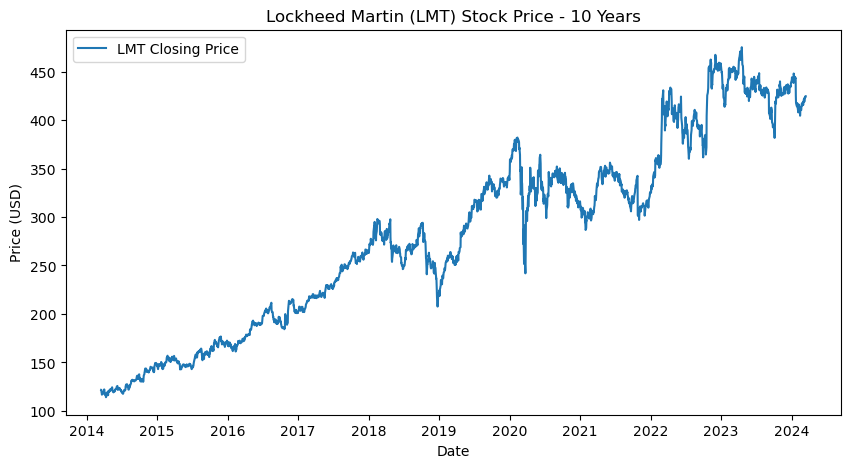

In [3]:
ticker = 'LMT'
data = yf.download(ticker, start='2014-03-15', end='2024-03-15')

plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='LMT Closing Price')
plt.title('Lockheed Martin (LMT) Stock Price - 10 Years')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

As a second step we now compute the log returns to stabilize the variance. After that we do Dickey-Fuller Test for stationarity. 

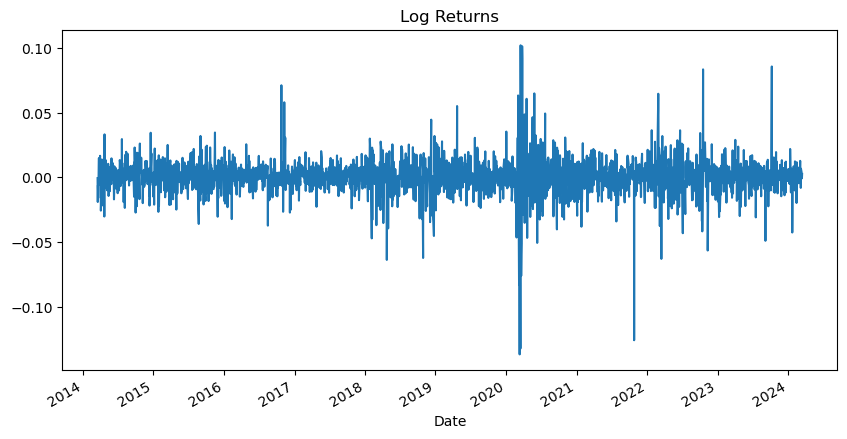

count    2516.000000
mean        0.000497
std         0.014013
min        -0.136525
25%        -0.005567
50%         0.000782
75%         0.007075
max         0.101906
Name: Log_Returns, dtype: float64


In [7]:
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

data['Log_Returns'].dropna().plot(figsize=(10, 5), title='Log Returns')
plt.show()
print(data['Log_Returns'].describe())

In [9]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

adf_test(data['Log_Returns'])

ADF Statistic: -18.186830175103875
p-value: 2.424993971870462e-30
Series is stationary


The ADF statistic of -18.19 is significantly lower than the critical threshold, and the p-value is effectively zero, strongly rejecting the null hypothesis of non-stationarity. This confirms that log-returns are suitable for modeling volatility without further transformation.

In the next step we model the ACF and PACF plots.

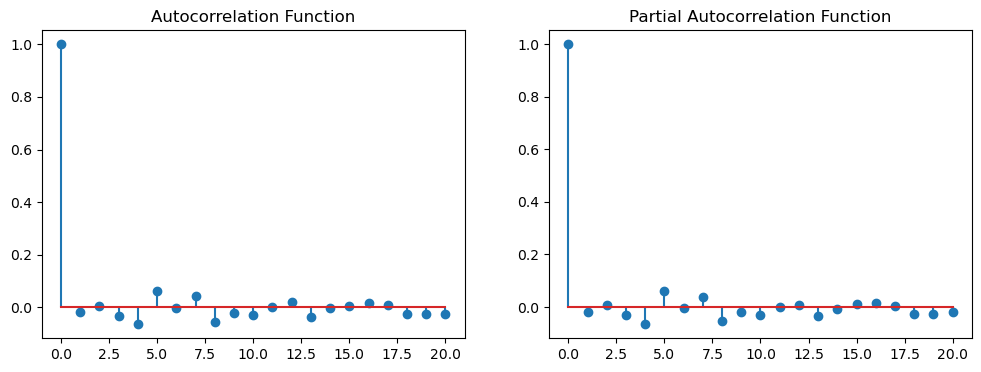

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].stem(acf(data['Log_Returns'].dropna(), nlags=20))
axes[0].set_title('Autocorrelation Function')
axes[1].stem(pacf(data['Log_Returns'].dropna(), nlags=20))
axes[1].set_title('Partial Autocorrelation Function')
plt.show()

Our exploratory data analysis (EDA) confirms several key properties of Lockheed Martin’s (LMT) stock returns, supporting the use of volatility models:
- The closing price time series plot shows an overall upward trend with clear volatility clustering, especially during major geopolitical and economic events (e.g., COVID-19 crash, Russia-Ukraine war).
- Log returns are computed to stabilize variance, and their distribution shows periods of high and low volatility.
- The Augmented Dickey-Fuller (ADF) test confirms stationarity, with a highly significant test statistic, meaning no further transformations are needed.
- ACF and PACF plots reveal minimal autocorrelation beyond lag 1, indicating that log-returns behave like white noise, making them suitable for ARCH/GARCH modeling rather than traditional ARIMA models.

Given the presence of volatility clustering and stationarity in log returns, we proceed with ARCH/GARCH models to better capture and forecast volatility patterns.

                       Constant Mean - ARCH Model Results                       
Dep. Variable:     Log_Returns_Rescaled   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         ARCH   Log-Likelihood:               -4213.61
Distribution:                    Normal   AIC:                           8433.22
Method:              Maximum Likelihood   BIC:                           8450.71
                                          No. Observations:                 2516
Date:                  Sat, Mar 15 2025   Df Residuals:                     2515
Time:                          17:43:10   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0450  2.684e-02     

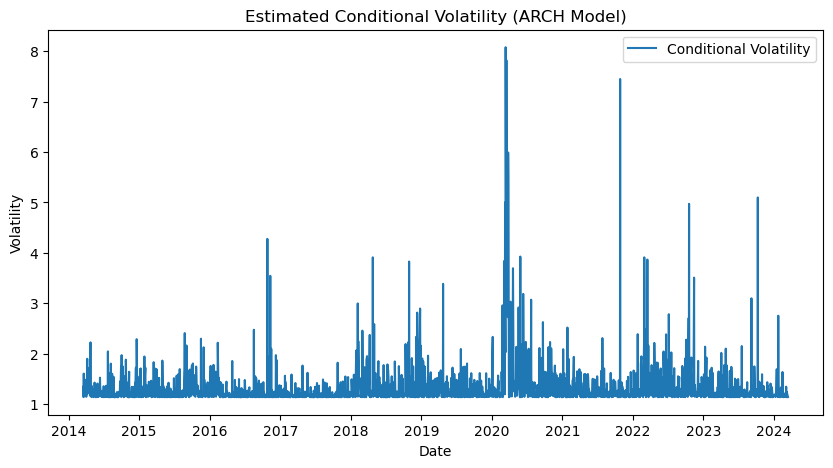

In [18]:
data['Log_Returns_Rescaled'] = data['Log_Returns'] * 100

arch_model_fit = arch_model(data['Log_Returns_Rescaled'].dropna(), vol='ARCH', p=1)
arch_result = arch_model_fit.fit(disp='off')
print(arch_result.summary())

plt.figure(figsize=(10, 5))
plt.plot(arch_result.conditional_volatility, label='Conditional Volatility')
plt.title('Estimated Conditional Volatility (ARCH Model)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Model Analysis:
- omega: Highly significant, meaning there is a strong baseline level of volatility
- alpha1: Highly significant, confirming the presence of volatility clustering
- mu: Not highly significant, but this aligns with financial theory that log returns usually have a near zero mean

The conditional volatility plot shows clear volatility clustering, with large spikes, especially around 2020 (COVID crash) and 2022 (market instability). The ARCH model partially captures these fluctuations, but there might be long-term volatility persistence that ARCH alone cannot model, as ARCH assumes that shocks are short lived, while real financial data often shows persistent volatility.

As a next step we now fit a GARCH(1,1) model incorporating past volatility.

                      Constant Mean - GARCH Model Results                       
Dep. Variable:     Log_Returns_Rescaled   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:               -4098.83
Distribution:                    Normal   AIC:                           8205.66
Method:              Maximum Likelihood   BIC:                           8228.98
                                          No. Observations:                 2516
Date:                  Sat, Mar 15 2025   Df Residuals:                     2515
Time:                          17:50:12   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0464  3.284e-02      1.414

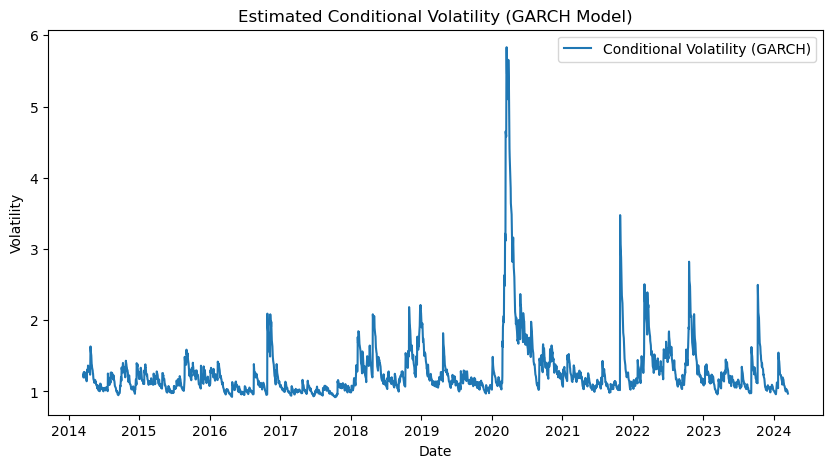

In [21]:
garch_model = arch_model(data['Log_Returns_Rescaled'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

plt.figure(figsize=(10, 5))
plt.plot(garch_result.conditional_volatility, label='Conditional Volatility (GARCH)')
plt.title('Estimated Conditional Volatility (GARCH Model)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Model Analysis:
- omega: Significant, indicating a baseline level of volatility
- alpha1: Highly significant, confirming short-term volatility clustering
- beta1: Highly significant, indicating strong volatility persistence
- AIC and BIC are lower than they were in the ARCH model, meaning GARCH is a better model

GARCH captures long-term volatility persistence better than ARCH. Spikes (e.g., 2020, 2022) are smoother compared to ARCH, meaning the model accounts for past volatility effects.

For the next step we check for asymmetry in volatilty before moving to risk analysis, as GARCH assumes a symmetric volatility response (positive and negative shocks have the same impact). In reality, negative shocks often cause more volatility than positive shocks. Should this be the case here we have to move to a different model (e.g. GJR-GARCH, EGARCH) to account for that.

In [27]:
asymmetry_corr = data['Log_Returns_Rescaled'].shift(1).corr(data['Log_Returns_Rescaled']**2)
print(f'Correlation between past returns and squared returns: {asymmetry_corr:.4f}')

Correlation between past returns and squared returns: -0.0008


As the correlation is near zero we stick with the GARCH model.

We now move to the Risk Analysis, specifically Value at Risk (VaR) and Expected Shortfall (ES):
- VaR: Estimates the maximum expected loss over a given time period at a specifies confidence level (we will use 95% and 99%). This metric helps investors to understand worst case losses in normal market conditions. For example, if we have a 1-day 95% CL VaR of -2%, this means 95% of the time losses will not exceed 2%.
- ES: Measures the average loss in worst case scenarios beyond the VaR threshold , as VaR only tells us the threshold loss but does not indicate how bad losses can get beyond that threshold. ES fixes this by measuring the expected loss in the worst 5% or 1% of cases. For example, a 1-day 95% CL ES of -3% means that if losses exceed the 95% VaR, the average loss will be 3%. This gives the investor a better understanding of the tail risk.

In [32]:
garch_forecast = garch_result.forecast(start=0)
vol_forecast = garch_forecast.variance.iloc[-1, 0] ** 0.5

z_95, z_99 = -1.645, -2.33
var_95 = z_95 * vol_forecast
var_99 = z_99 * vol_forecast
print(f"95% Value at Risk (VaR): {var_95:.4f}")
print(f"99% Value at Risk (VaR): {var_99:.4f}")

es_95 = -np.mean(data['Log_Returns_Rescaled'][data['Log_Returns_Rescaled'] < var_95])
es_99 = -np.mean(data['Log_Returns_Rescaled'][data['Log_Returns_Rescaled'] < var_99])
print(f"95% Expected Shortfall (ES): {es_95:.4f}")
print(f"99% Expected Shortfall (ES): {es_99:.4f}")

95% Value at Risk (VaR): -1.5785
99% Value at Risk (VaR): -2.2358
95% Expected Shortfall (ES): 2.7471
99% Expected Shortfall (ES): 3.7301


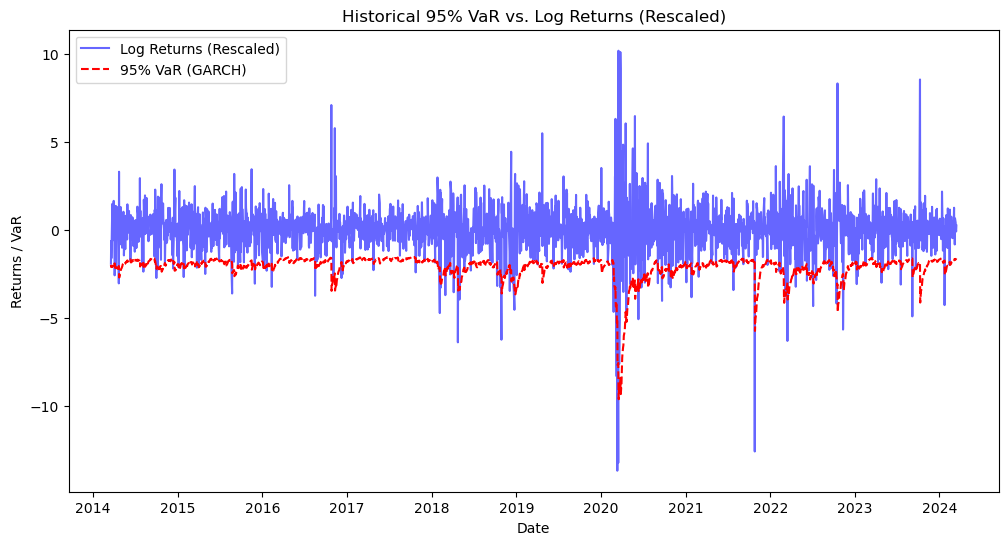

In [48]:
aligned_returns = data['Log_Returns_Rescaled'].iloc[2:]  # Drop two rows to match GARCH output
rolling_volatility = garch_result.conditional_volatility.iloc[1:]  # Drop first GARCH value for full alignment

z_95 = -1.645
rolling_var_95 = z_95 * rolling_volatility

aligned_dates = aligned_returns.index[:len(rolling_var_95)]

plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, aligned_returns[:len(rolling_var_95)], label="Log Returns (Rescaled)", color='blue', alpha=0.6)
plt.plot(aligned_dates, rolling_var_95, label="95% VaR (GARCH)", color='red', linestyle='dashed')
plt.title("Historical 95% VaR vs. Log Returns (Rescaled)")
plt.xlabel("Date")
plt.ylabel("Returns / VaR")
plt.legend()
plt.show()

The ES is larger than the VaR which confirms the tail risk is higher than just the worst case threshold.

Final Analysis of the VaR vs Log Returns plot
- Log Returns (Blue Line): Daily log returns fluctuate around zero, with high volatility spikes, especially during market crises (e.g., 2020 COVID crash). Periods of low and high volatility clustering are visible, confirming the usefulness of the GARCH model.
- 95% VaR (Red Line): The VaR line remains below log returns most of the time, as expected. During high-volatility periods (e.g., 2020), VaR increases, indicating higher risk. There are several instances where actual returns breach VaR, highlighting extreme losses.

Financial Implications:
The model correctly identifies risky periods where losses could exceed expectations. The GARCH-based VaR dynamically adjusts to market conditions, unlike static VaR models.